# Description
The objective of this analysis is to understand the benefits of the use of survival analysis for the modelling of credit risk lifetime default curves.
<br> The standard approach used in the industry is to:
1. Train a classification model in a single target, usually default in 12 months
2. Segment the portfolio in homogeneous risk groups.
3. Calibrate the PD in 12 months over each group.
4. calibrate the lifetime pd curve over each group.

<br> The approach described above breaks down each modelling component in different challenges, the scorecard is only worried with discrimination of the population between clients with low and high risk of defaulting while the calibration of the risk curves deal with both level and shape of the risk curves. This allows for a modular approach, although it implements additional steps in the modelling.
<br> An alternative approach would be using survival analysis methods which allows the modelling of the full lifetime curve in one single model.

This analysis aims to explore the use of survival models to calibrate pd lifetime risk curves

This notebook will create a syntetic set of data upon which the analysis will be done

# Setup

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy
from IPython.display import Image

# Data Creation

In [2]:
def fit_power(x, shape, scale):
  return (scale * x ** (-shape))

def fit_exp(x, shape, scale):
  result = scale * np.exp(np.multiply(-shape, x))
  return result

def fit_weibull(x, shape, scale, d):
  result = (shape/scale)*np.power(((x+d)/scale), (shape-1)) * np.exp(-1 * np.power(((x+d)/scale), shape))
  return result

def fit_gamma(x, shape, scale, d=0):
  from scipy.special import gamma
  result = ((1 / (gamma(shape) * (scale ** shape))) * ((x+d) ** (shape - 1)) * np.exp(np.multiply(-1, (x+d)) / scale))
  return result

def logNormFunc(x, a, b, d):
  result = (1 / ((x+d) * b * np.power(2* np.pi, 1/2))) * np.exp(-1*(np.power(np.log(x+d) - a, 2) / (2*np.power(b, 2))))
  return result

def gamma_pdf(x, a, b):
  from scipy.special import gamma
  return (np.power(x, (a - 1)) * np.exp(np.divide(np.multiply(-1, x), b))) / (np.power(b, a) * gamma(a))

def exp_decay(x, a, b):
  return a * np.exp(np.multiply(-b, x))

def beta_pdf(x, a, b):
  from scipy.special import beta
  return np.divide((np.divide(x, np.power(60, (a - 1))) * np.power((1 - np.divide(x, 60)), (b - 1))), beta(a, b))

/home/neon/Documents/Survival Analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



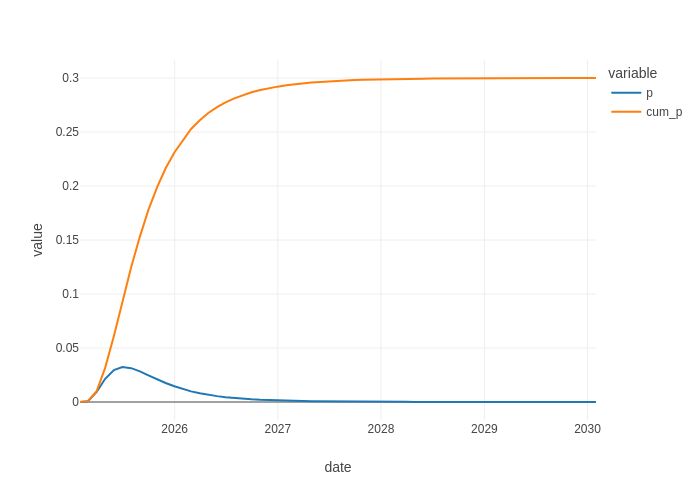

In [6]:
func_parameters =  dict(
    a = 2,
    b = 0.6,
    d = 0
)


def generate_pd_curve(func, 
                      parameters: dict,
                      n_default_months: int,
                      cumulative_pd: float):
    df = pd.DataFrame(range(0, n_default_months+1), columns=["default_month"])
    df['date'] = pd.date_range(start='2025-01-31', periods=n_default_months+1, freq='ME')
    df['default_month'] = df['default_month']
    df['p'] = func(df['default_month'], **parameters) 
    df['p'] = df['p'].fillna(0)
    df['p'] = (df['p'] / df['p'].sum()) * cumulative_pd
    df['cum_p'] = df['p'].cumsum()
    df = df.drop('default_month', axis='columns')
    return df

data = generate_pd_curve(logNormFunc, func_parameters, 60, 0.3)

data_chart = data.copy()

fig = px.line(
    data_chart,
    x=data_chart["date"].dt.strftime("%Y-%m-%d"),
    y=["p", 'cum_p'],
    template = 'none',
    width=1000
)
# fig
Image(fig.to_image("png"))

In [7]:

def generate_sample_from_prob_curve(df: pd.DataFrame, n_samples: int):
    range_i = range(1, n_samples+1)
    result = []
    for i in range_i:
        df_temp = df.copy()
        df_temp['is_default'] = np.random.binomial(1, p=df_temp['p'])
        df_temp['id'] = i
        result.append(df_temp)

    return pd.concat(result)

def withDefaultFlag(df: pd.DataFrame):
    result = df.copy()
    result['default_date_aux'] = pd.to_datetime(np.where(result['is_default']==1, result['date'], None))
    result = result.sort_values(['id', 'date'])
    result['default_date'] = result.groupby('id')['default_date_aux'].transform('min')
    result = result.drop('default_date_aux', axis='columns')
    result['default_month'] = pd.to_numeric(np.where(result['default_date'].isnull(), None,
                                       (result['default_date'].dt.to_period('M').astype(int) 
                                        - result['date'].dt.to_period('M').astype(int))))
    result['default_flag'] = np.where(result['default_month'].isnull(),0,1)
    return result

def filterAlreadyDefaulted(df: pd.DataFrame):
    filter_df = (df['default_month']>0) | (df['default_month'].isnull())
    result = df[filter_df]
    return result

def withCompleteDefaultMonths(df: pd.DataFrame, lifetime: int):
    default_months = pd.DataFrame(range(1,lifetime+1), columns=['complete_default_months'])
    id_df = df[['date', 'id']].drop_duplicates()\
                .merge(default_months, how='cross')
    
    result = id_df.merge(df, on=['date', 'id'], how='outer')
    result['default_flag'] = np.where(result['default_month'] == result['complete_default_months'], 1, 0)
    result = result\
                .drop('default_month', axis='columns')\
                .rename({'complete_default_months':'default_month'}, axis='columns')
    result['cum_defaults'] = result.sort_values(['date', 'id']).groupby(['date', 'id'])['default_flag'].transform('cumsum')
    return result

default_data = data\
.pipe(generate_sample_from_prob_curve, 1000)\
.pipe(withDefaultFlag)\
.pipe(filterAlreadyDefaulted)\
.pipe(withCompleteDefaultMonths, 60)

default_data

,date,id,default_month,p,cum_p,is_default,default_date,default_flag,cum_defaults
0,2025-01-31,1,1,0.000000,0.0,0,NaT,0,0
1,2025-01-31,1,2,0.000000,0.0,0,NaT,0,0
2,2025-01-31,1,3,0.000000,0.0,0,NaT,0,0
3,2025-01-31,1,4,0.000000,0.0,0,NaT,0,0
4,2025-01-31,1,5,0.000000,0.0,0,NaT,0,0
...,...,...,...,...,...,...,...,...,...
2892175,2030-01-31,1000,56,0.000008,0.3,0,NaT,0,0
2892176,2030-01-31,1000,57,0.000008,0.3,0,NaT,0,0
2892177,2030-01-31,1000,58,0.000008,0.3,0,NaT,0,0
2892178,2030-01-31,1000,59,0.000008,0.3,0,NaT,0,0


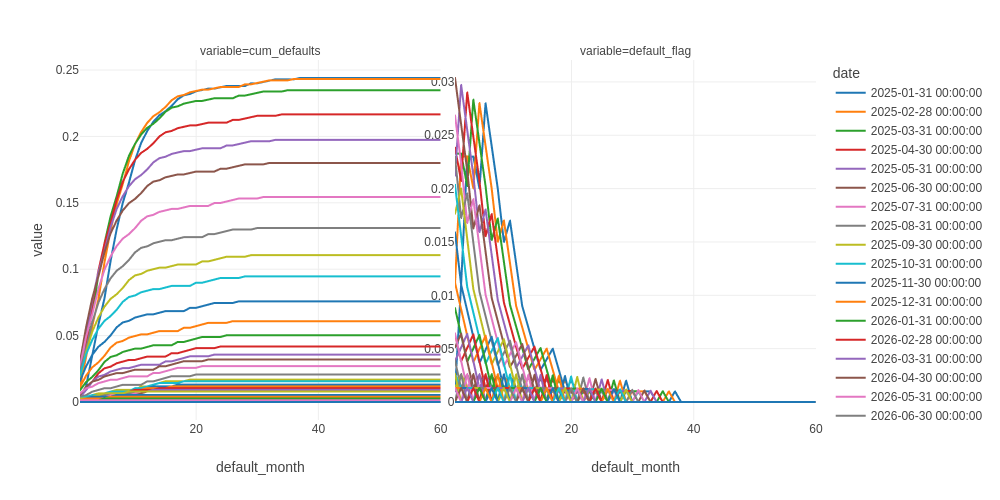

In [11]:
# data_chart = default_data\
#     .groupby(['date','default_month'])\
#     .agg({
#         'cum_defaults': 'mean',
#         'default_flag': 'mean'
#     }) \
#     .reset_index()\
#     .melt(id_vars=['date', 'default_month'])


fig = px.line(
    data_chart,
    x='default_month',
    y='value',
    facet_col='variable',
    color='date',
    template='none',
    width=1000
)

fig.update_yaxes(matches=None, showticklabels=True)
Image(fig.to_image("png", width=1000))
